Note: this notebook is written to work in Colab, and thus it installs the `eigenlearning` repo from Github. If the repo is already present on the system, the install cell can be skipped and the modules imported directly, and the saving to Drive can be replaced with saving locally.

Another note: we assembled these notebooks out of modular parts from other notebooks, and thus we have not run all of them. If something doesn't work, let us know and we'll be glad to know and happy to fix it.

# Imports and installs

In [1]:
import pickle

import matplotlib.gridspec as gridspec
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt

import jax
from jax import grad
import jax.numpy as jnp
import jax.random as random

!pip install -q git+https://www.github.com/google/neural-tangents.git@no_experimental

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 2.0 MB/s eta 0:00:00


In [2]:
import os
import sys

if os.path.isdir('/content/eigenlearning'):
    !rm -r '/content/eigenlearning'
!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

DIRECTORY = 'eigenlearning/'

main_dir = '/content/drive/MyDrive/' + DIRECTORY
expt_dir = main_dir + 'lrn_mse_curves/'
for dir in [main_dir, expt_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

Mounted at /content/drive


# Run experiment and save data

In [5]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)
kernel_fn = net_fns[2]

In [6]:
def one_hot(size, one_ind):
    f = [0]*size
    f[one_ind] = 1
    return jnp.array(f)

def get_lrn_mse_theory(spectrum, n_trains, kk):
    lrn_results = {}
    mse_results = {}

    for k in kk:
        # target function is just the k-th mode
        eigenlevel_ind = spectrum.get_mode_eigenlevel(k)
        eigenlevel_coeffs = one_hot(spectrum.n_levels, eigenlevel_ind)
        lrn_preds, mse_preds = [], []
        for n_train in n_trains:
            theory_pred = theoretical_predictions(n_train, eigenlevel_coeffs, spectrum)
            lrn_preds.append(theory_pred["learnability"])
            mse_preds.append(theory_pred["test_mse"])
        lrn_results[k] = lrn_preds
        mse_results[k] = mse_preds

    return (lrn_results, mse_results)

In [7]:
def get_lrn_mse_expt(n_trains, kk, get_dataset_fn, num_trials=30):
    lrn_results = {}
    mse_results = {}    
    key = jnp.array([0, 42], dtype='uint32')

    for k in kk:
        all_krn_lrns, all_krn_mses = [], []
        all_nn_lrns, all_nn_mses = [], []
        for n_train in n_trains:
            krn_lrns, krn_mses = [], []
            nn_lrns, nn_mses = [], []
            for _ in range(num_trials):
                dataset = get_dataset_fn(k, n_train)
                y_test = dataset[3]
                
                _, krn_test_y_hat = train_kernel(kernel_fn, dataset, ridge=0)
                krn_learnability, krn_mse, _, _ = compute_metrics(y_test, krn_test_y_hat)
                krn_lrns.append(krn_learnability)
                krn_mses.append(krn_mse)
                
                key, subkey = random.split(key, 2)
                _, nn_test_y_hat, _ = train_net(net_fns, dataset, loss=mse, subkey=subkey,
                                                        n_epochs=10000, lr=0.5, stop_mse=1e-5)            
                nn_learnability, nn_mse, _, _ = compute_metrics(y_test, nn_test_y_hat)
                nn_lrns.append(nn_learnability)
                nn_mses.append(nn_mse)
            all_krn_lrns.append(krn_lrns)
            all_nn_lrns.append(nn_lrns)
            all_krn_mses.append(krn_mses)
            all_nn_mses.append(nn_mses)
            print('.', end='')
        lrn_results[k] = (all_krn_lrns, all_nn_lrns)
        mse_results[k] = (all_krn_mses, all_nn_mses)
        print()
    
    return (lrn_results, mse_results)

def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean()
            

### Unit Circle

In [ ]:
log2_M = 8
M = 2**log2_M
domain = UnitCircle(M)
spectrum = domain.get_spectrum(kernel_fn)

kk = [0, 2, 5, 10]
n_trains_expt = jnp.logspace(1, log2_M, num=log2_M+1, base=2).astype(int)
n_trains_theory = jnp.logspace(0, log2_M, num=50, base=2)

In [ ]:
## THEORY

results = get_lrn_mse_theory(spectrum, n_trains_theory, kk)
save_results = (n_trains_theory, *results)
with open(expt_dir+'/unit_circle_theory.pickle', 'wb') as handle:
    pickle.dump(save_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
## EXPT

def circle_dataset_closure(M, domain, key):

    def get_circle_dataset(k, n_train):
        nonlocal key
        target = {(k, 'c'): 1}
        key, dataset_key = random.split(key, 2)
        dataset = domain.get_dataset(target, n_train, n_test=M, subkey=dataset_key)
        return dataset
    
    return get_circle_dataset

key = jnp.array([0, 42], dtype='uint32')
get_dataset_fn = circle_dataset_closure(M, domain, key)
results = get_lrn_mse_expt(n_trains_expt, kk, get_dataset_fn, num_trials=30)
save_results = (n_trains_expt, *results)
with open(expt_dir+'/unit_circle_expt.pickle', 'wb') as handle:
    pickle.dump(save_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Hypercube

In [ ]:
dim = 8
domain = Hypercube(dim)
spectrum = domain.get_spectrum(kernel_fn)

kk = [0, 1, 3, 8]
n_trains_expt = jnp.logspace(1, dim, num=dim+1, base=2).astype(int)
n_trains_theory = jnp.logspace(0, dim, num=50, base=2)

In [ ]:
## THEORY

results = get_lrn_mse_theory(spectrum, n_trains_theory, kk)
save_results = (n_trains_theory, *results)
with open(expt_dir+'/hypercube_theory.pickle', 'wb') as handle:
    pickle.dump(save_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
## EXPT

def cube_dataset_closure(dim, domain, key):

    def get_cube_dataset(k, n_train):
        nonlocal key
        target = {k : 1}
        key, dataset_key = random.split(key, 2)
        dataset = domain.get_dataset(target, n_train, n_test=2**dim, subkey=dataset_key)
        return dataset
    
    return get_cube_dataset

key = jnp.array([0, 42], dtype='uint32')
get_dataset_fn = cube_dataset_closure(dim, domain, key)
results = get_lrn_mse_expt(n_trains_expt, kk, get_dataset_fn, num_trials=30)
save_results = (n_trains_expt, *results)
with open(expt_dir+'/hypercube_expt.pickle', 'wb') as handle:
    pickle.dump(save_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Hypersphere

In [ ]:
dim = 8
domain = Hypersphere(dim)
spectrum = domain.get_spectrum(kernel_fn)

kk = [0, 1, 2, 3, 4]
n_trains_expt = jnp.logspace(1, dim, num=dim+1, base=2).astype(int)
n_trains_theory = jnp.logspace(0, dim, num=50, base=2)

In [ ]:
## THEORY

results = get_lrn_mse_theory(spectrum, n_trains_theory, kk)
save_results = (n_trains_theory, *results)
with open(expt_dir+'/hypersphere_theory.pickle', 'wb') as handle:
    pickle.dump(save_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
## EXPT

def sphere_dataset_closure(dim, domain, key):

    def get_sphere_dataset(k, n_train):
        nonlocal key
        target = {k : 1}
        key, dataset_key = random.split(key, 2)
        dataset = domain.get_dataset(target, n_train, n_test=2**dim, subkey=dataset_key)
        return dataset
    
    return get_sphere_dataset

key = jnp.array([0, 42], dtype='uint32')
get_dataset_fn = sphere_dataset_closure(dim, domain, key)
results = get_lrn_mse_expt(n_trains_expt, kk, get_dataset_fn, num_trials=30)
save_results = (n_trains_expt, *results)
with open(expt_dir+'/hypersphere_expt.pickle', 'wb') as handle:
    pickle.dump(save_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Image datasets

In [96]:
log2_M = 11
M = 2**log2_M
tasks = [('mnist', (0,1)), ('mnist', (3,8)), ('cifar10', (2,9)), ('cifar10', (4,7))]
task_titles = ["MNIST 0/1", "MNIST 3/8", "CIFAR10 bird/truck", "CIFAR10 deer/horse"]

n_trains_expt = jnp.logspace(1, log2_M, num=log2_M+1, base=2).astype(int)
n_trains_theory = jnp.logspace(0, log2_M, num=50, base=2)

..................................................
..................................................
Files already downloaded and verified
Files already downloaded and verified
..................................................
Files already downloaded and verified
Files already downloaded and verified
..................................................


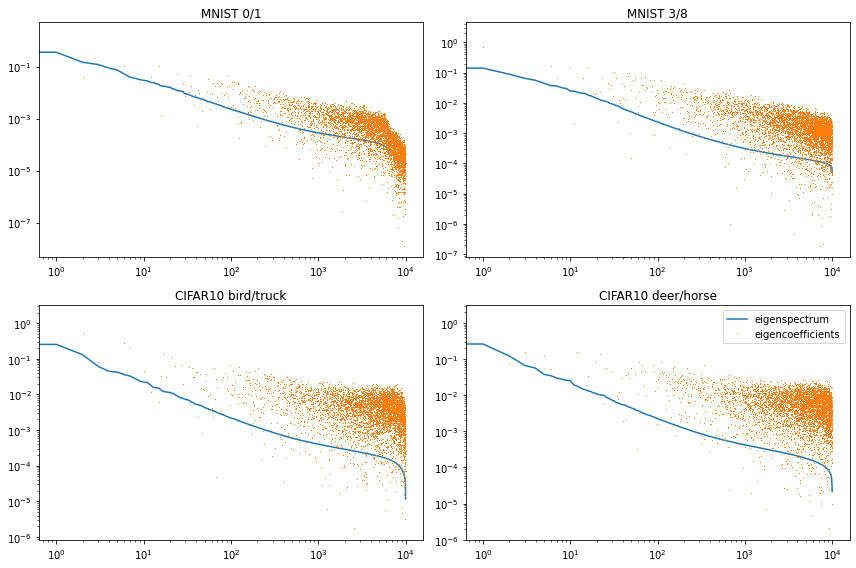

In [98]:
## THEORY

key = jnp.array([0, 42], dtype='uint32')

lrn_results = {}
mse_results = {}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, task in enumerate(tasks):
    dataset_name, classes = task
    domain = ImageData(dataset_name)
    key, dataset_key = random.split(key, 2)

    train_X, train_y, _, _ = domain.get_dataset(n_train=10000, classes=classes, subkey=dataset_key)
    eigendata = domain.get_eigendata(kernel_fn, train_X, train_y)
    eigenlevel_coeffs = eigendata["eigenlevel_coeffs"]
    spectrum = eigendata["spectrum"]

    ax = axes.flat[i]
    ax.plot(spectrum.lambdas, label="eigenspectrum")
    ax.plot(eigenlevel_coeffs, linestyle='None', marker=',', label="eigencoefficients")
    ax.set_title(task_titles[i])
    ax.set_yscale('log')
    ax.set_xscale('log')

    lrn_preds, mse_preds = [], []
    for n_train in n_trains_theory:
        theory_pred = theoretical_predictions(n_train, eigenlevel_coeffs, spectrum)
        lrn_preds.append(theory_pred["learnability"])
        mse_preds.append(theory_pred["test_mse"])
        print('.', end='')
    lrn_results[task] = lrn_preds
    mse_results[task] = mse_preds
    print()

plt.legend()
plt.tight_layout()
plt.show()
save_results = (n_trains_theory, lrn_results, mse_results)
with open(expt_dir+'/image_theory.pickle', 'wb') as handle:
    pickle.dump(save_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
## EXPT

def image_dataset_closure(M, key):

    def get_image_dataset(task, n_train):
        nonlocal key
        dataset_name, classes = task
        domain = ImageData(dataset_name)
        key, dataset_key = random.split(key, 2)
        dataset = domain.get_dataset(n_train, classes=classes, subkey=dataset_key)
        return dataset
    
    return get_image_dataset

key = jnp.array([0, 42], dtype='uint32')
get_dataset_fn = image_dataset_closure(M, key)
results = get_lrn_mse_expt(n_trains_expt, tasks, get_dataset_fn, num_trials=30)
save_results = (n_trains_expt, *results)
with open(expt_dir+'/image_expt.pickle', 'wb') as handle:
    pickle.dump(save_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plotting

In [99]:
## LOAD AND PROCESS DATA ##

def process_expt_results(results):
    n_trains, lrn_results, mse_results = results
    def process(results):
        for k, (krn, nn) in results.items():
            krn, nn = jnp.array(krn), jnp.array(nn) 
            results[k] = (
                (krn.mean(axis=1), krn.std(axis=1)),
                (nn.mean(axis=1), nn.std(axis=1))
            )
        return results
    return n_trains, process(lrn_results), process(mse_results)
    

domains = ["unit_circle", "hypercube", "hypersphere", "image"]
titles = ["Unit Circle", "8-cube", "7-sphere", "Image"]
plot_info = {}
image_labels = {('mnist', (0,1)): "MNIST 0/1",
                ('mnist', (3,8)): "MNIST 3/8",
                ('cifar10', (2,9)): "CIFAR10 bird/truck",
                ('cifar10', (4,7)): "CIFAR10 deer/horse"}

for domain, title in zip(domains, titles):
    with open('{}/{}_theory.pickle'.format(expt_dir, domain), 'rb') as handle:
        theory_results = pickle.load(handle)
    
    with open('{}/{}_expt.pickle'.format(expt_dir, domain), 'rb') as handle:
        expt_results = pickle.load(handle)
    expt_results = process_expt_results(expt_results)
    
    if domain != "image":
        pass
    plot_info[domain] = {
        "title": title,
        "theory": theory_results,
        "expt": expt_results,
    }

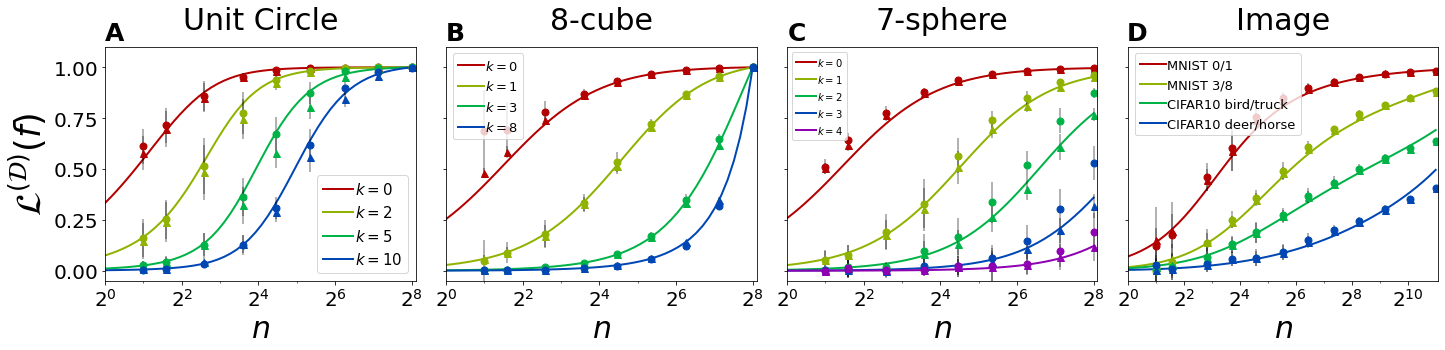

In [100]:
## PLOTS ##

import math

def get_plot_color(ind, ncolors=10):
    colorlist = [hsv_to_rgb((h,1,.7)) for h in jnp.linspace(0, 0.8, ncolors)]
    return colorlist[ind%ncolors]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, domain in enumerate(plot_info):
    info = plot_info[domain]
    ax = axes[i]
    ax.set_xscale('symlog', linthresh=1)
    
    theory_results = info["theory"]
    n_trains, lrn_results, _ = theory_results
    n_modes = len(lrn_results)
    for j, (k, lrn_preds) in enumerate(lrn_results.items()):
        color = get_plot_color(j, 5)
        label = image_labels[k] if i==3 else f'$k={k}$'
        ax.plot(n_trains, lrn_preds, color=color, lw=2, label=label)
    
    expt_results = info["expt"]
    n_trains, lrn_results, _ = expt_results
    n_modes = len(lrn_results)
    for j, (k, lrn_stats) in enumerate(lrn_results.items()):
        color = get_plot_color(j, 5)
        (krn_mean, krn_std), (nn_mean, nn_std) = lrn_stats
        ax.errorbar(n_trains, krn_mean, yerr=krn_std,
                    fmt='^', color=color, ecolor=(0,0,0,.3), markersize=7, elinewidth=2)
        ax.errorbar(n_trains, nn_mean, yerr=nn_std,
                    fmt='o', color=color, ecolor=(0,0,0,.3), markersize=7, elinewidth=2)
      
    ax.legend(ncol=1, fontsize=[15,13,10,13][i], handletextpad=.1, frameon=True)

    ax.set_xticks([2**i for i in range(0, round(math.log2(max(n_trains))+1), 2)], minor=False)
    ax.set_xticks([2**i for i in range(1, round(math.log2(max(n_trains))-1), 2)], minor=True)
    ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(0, round(math.log2(max(n_trains))+1), 2)], minor=False)
    ax.set_xticklabels([], minor=True)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if i > 0:
        ax.set_yticklabels([])
    ax.set_ylim((-.05, 1.1))
    ax.set_xlim((1, 2**8.1))
    if i==3:
        ax.set_xlim((1, 2**11.1))
    ax.set_xlabel('$n$', fontsize=30)
    if i == 0:
        ax.set_ylabel(r'$\mathcal{L}^{(\mathcal{D})}(f)$', fontsize=35)
  
    ax.set_title(info["title"], fontsize=30, y=1.05)
    ax.text(.03, 1.03, 'ABCD'[i], transform=ax.transAxes, size=25, weight='bold', ha='center')

fig.tight_layout()

plt.show()
# plt.savefig('lrn_curves.pdf')

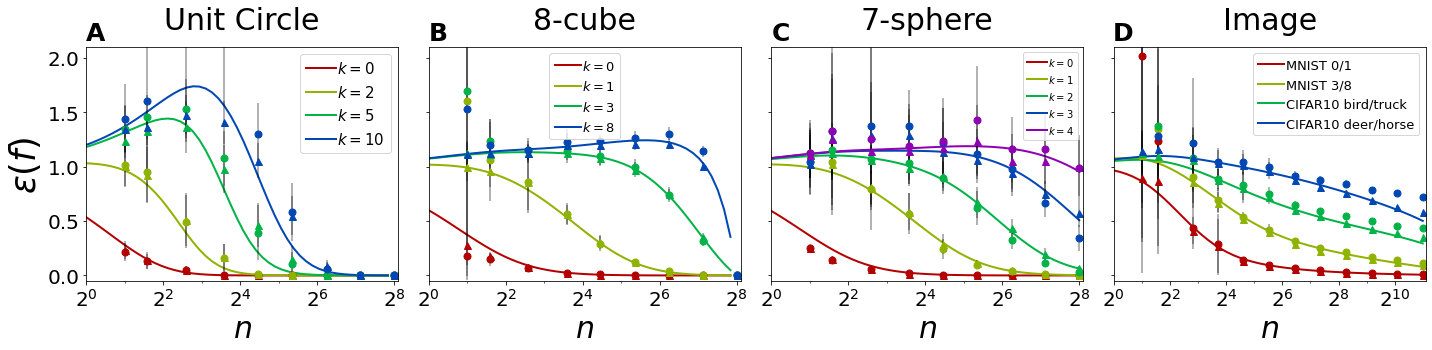

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, domain in enumerate(plot_info):
    info = plot_info[domain]
    ax = axes[i]
    ax.set_xscale('symlog', linthresh=1)
    
    theory_results = info["theory"]
    n_trains, _, mse_results = theory_results
    n_modes = len(mse_results)
    for j, (k, mse_preds) in enumerate(mse_results.items()):
        color = get_plot_color(j, 5)
        label = image_labels[k] if i==3 else f'$k={k}$'
        ax.plot(n_trains, mse_preds, color=color, lw=2, label=label)
    
    expt_results = info["expt"]
    n_trains, _, mse_results = expt_results
    n_modes = len(mse_results)
    for j, (k, mse_stats) in enumerate(mse_results.items()):
        color = get_plot_color(j, 5)
        (krn_mean, krn_std), (nn_mean, nn_std) = mse_stats
        ax.errorbar(n_trains, krn_mean, yerr=krn_std,
                    fmt='^', color=color, ecolor=(0,0,0,.3), markersize=7, elinewidth=2)
        ax.errorbar(n_trains, nn_mean, yerr=nn_std,
                    fmt='o', color=color, ecolor=(0,0,0,.3), markersize=7, elinewidth=2)
      
    ax.legend(ncol=1, fontsize=[15,13,10,13][i], handletextpad=.1, frameon=True)

    ax.set_xticks([2**i for i in range(0, round(math.log2(max(n_trains))+1), 2)], minor=False)
    ax.set_xticks([2**i for i in range(1, round(math.log2(max(n_trains))-1), 2)], minor=True)
    ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(0, round(math.log2(max(n_trains))+1), 2)], minor=False)
    ax.set_xticklabels([], minor=True)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if i > 0:
        ax.set_yticklabels([])
    ax.set_ylim((-.05, 2.1))
    ax.set_xlim((1, 2**8.1))
    if i==3:
        ax.set_xlim((1, 2**11.1))
    ax.set_xlabel('$n$', fontsize=30)
    if i == 0:
        ax.set_ylabel(r'$\varepsilon(f)$', fontsize=35)
  
    ax.set_title(info["title"], fontsize=30, y=1.05)
    ax.text(.03, 1.03, 'ABCD'[i], transform=ax.transAxes, size=25, weight='bold', ha='center')

fig.tight_layout()

plt.show()
# plt.savefig('mse_curves.pdf')